In [2]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
import math
from datetime import datetime as dt
sys.path.append('C:\\Users\\jades\\1001 Intro to Data Science Notebooks\\Project\\wildfires-1001\\code\\functions')
from gis_processing import *

import warnings
warnings.simplefilter('ignore')

In [61]:
gitdir = 'C:/Users/jades/1001 Intro to Data Science Notebooks/Project/wildfires-1001/'

In [62]:
subdir_from = 'data/clean_data/county_grid/'
filename_from = 'county_grid.shp'

county_grid_map = gpd.read_file(gitdir + subdir_from + filename_from)

county_grid_map = county_grid_map.to_crs(crs='epsg:4326')

In [102]:
subdir_from = 'data/clean_data/NOAA-station-lists/'
#filename_from = 'station_list_v2.csv'
#filename_from = 'station_list_PRCP.csv'
#filename_from = 'station_list_SNOW.csv'
#filename_from = 'station_list_TMAXTMIN.csv'
filename_from = 'station_list_TOBS.csv'

noaa = pd.read_csv(gitdir + subdir_from + filename_from)

noaa_gdf = gpd.GeoDataFrame(noaa, geometry = gpd.points_from_xy(noaa.LONGITUDE, noaa.LATITUDE), \
                            crs={'init' :'epsg:4326'})

In [103]:
#Calculate the centroids of the grids and the stations
county_grid_map['centroid'] = county_grid_map.centroid
county_grid_map['x'] = county_grid_map.centroid.x
county_grid_map['y'] = county_grid_map.centroid.y

In [104]:
#Create a dummy key to enable us to cross join, do the join, the drop the key
county_grid_map['key'] = 1
noaa_gdf['key'] = 1

distance_calc = county_grid_map[['GRID_ID', 'geometry', 'x', 'y', 'key']].merge(noaa_gdf[['ID', 'LONGITUDE', 'LATITUDE', 'key']], how='inner', left_on='key', right_on='key')

county_grid_map = county_grid_map.drop(['key'], axis=1)
noaa_gdf = noaa_gdf.drop(['key'], axis=1)

In [105]:
#Calculate the distance between each grid centroid and station
#Map each grid to its nearest station
distance_calc['distance'] = ((distance_calc['x']-distance_calc['LONGITUDE'])**2 + (distance_calc['y']-distance_calc['LATITUDE'])**2)**(1/2)

#station_grid_map = distance_calc.loc[distance_calc.groupby('GRID_ID').distance.idxmin()].reset_index(drop=True)[['GRID_ID', 'ID', 'distance']]
station_grid_map_TOBS = distance_calc.loc[distance_calc.groupby('GRID_ID').distance.idxmin()].reset_index(drop=True)[['GRID_ID', 'ID', 'distance']]

In [106]:
#Save the cleaned dataframe
subdir_to = 'data/clean_data/mapping_tables/'
filename_to = 'station_grid_map_TOBS.csv'
station_grid_map_TOBS.to_csv(gitdir + subdir_to + filename_to, index=False)

In [107]:
#Filter our full list of stations down to the ones mapped
noaa_gdf_mapped = noaa_gdf.merge(station_grid_map_TOBS, how='inner', left_on='ID', right_on='ID')

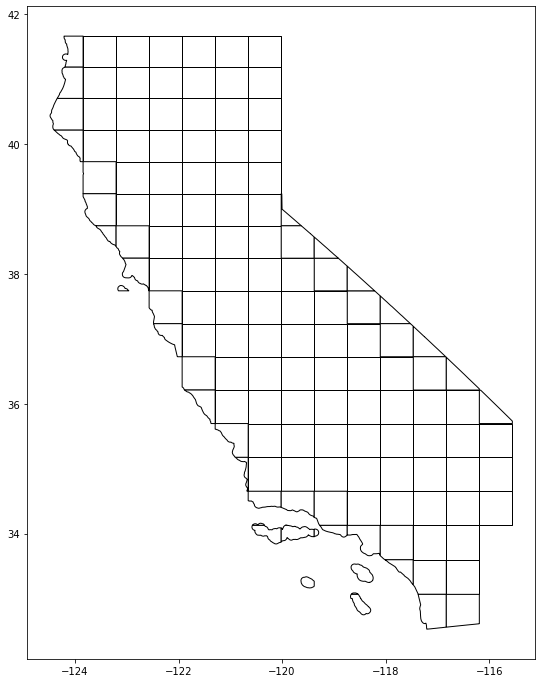

In [108]:
county_grid_map.plot(color = 'white', edgecolor = 'black', figsize = (12,12))

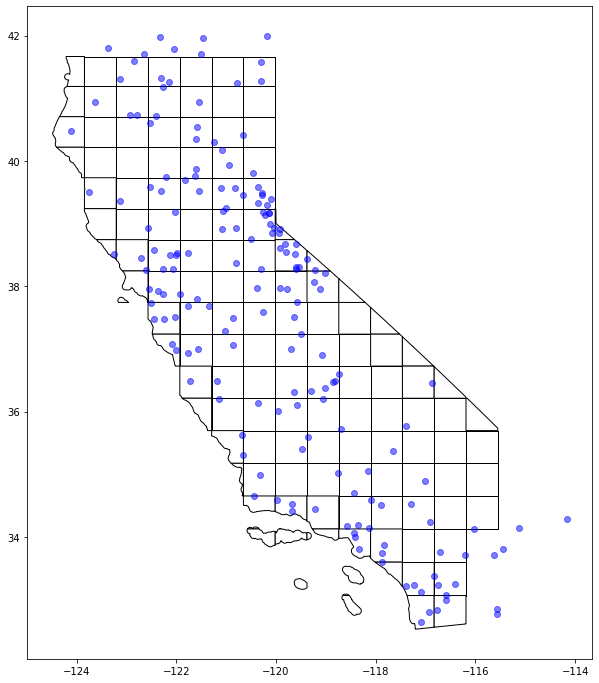

In [109]:
ax = county_grid_map.plot(color = 'white', edgecolor = 'black', figsize = (12,12))
noaa_gdf.plot(ax=ax, color = 'blue', alpha = 0.5, figsize = (12,12))

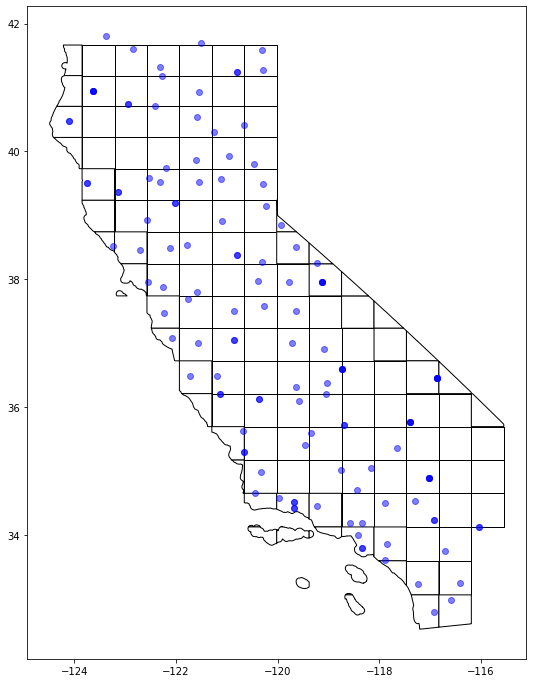

In [110]:
ax = county_grid_map.plot(color = 'white', edgecolor = 'black', figsize = (12,12))
noaa_gdf_mapped.plot(ax=ax, color = 'blue', alpha = 0.5, figsize = (12,12))